# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [12]:
from dateutil.rrule import HOURLY
# Installs all required packages
!pip install -r requirements.txt



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import os

import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

from dotenv import load_dotenv
from requests import HTTPError


# Load environment variables from .env file
load_dotenv()

api_key = os.environ.get('OPENWEATHER_API_KEY')

# Add any other setup code here
if os.environ.get('OPENWEATHER_API_KEY') is None:
    print("Warning: OPENWEATHER_API_KEY not set. Please set it in your environment variables.")

    # Uncomment and replace with your actual API key if you don't want to use .env file
    # os.environ['OPENWEATHER_API_KEY'] = 'your_api_key_here'



## 🌤️ Weather Data Functions

In [3]:
def get_weather_data(location, forecast_day=5):
    """
    Fetch weather data for a given location and forecast day.

    Args:
        location (str): The location to fetch weather data for.
        forecast_day (int): The number of days to forecast (default is 5).

    Returns:
        dict: Weather data for the specified location and forecast day.
    """

    # Use OpenWeatherMap API to get weather details from location
    try:
        # openweathermap forecast provides 3-hourly data
        # for 5 days, so we need to convert it to daily data



        if forecast_day < 1:
            raise ValueError("Forecast day must be at least 1.")
        if forecast_day > 5:
            raise ValueError("Forecast day must be at most 5.")

        forecast_day *= 8 # 3-hourly data for 5 days

        weather_data_response = requests.get(f'https://api.openweathermap.org/data/2.5/forecast?q={location},au'
                                             f'&appid={api_key}&cnt={forecast_day}&units=metric')

        # Raise an error for bad responses
        if weather_data_response.status_code != 200:
            if weather_data_response.status_code == 404:
                raise HTTPError("Location not found. Please check the location name and try again.")
            else:
                raise HTTPError(f"Error fetching weather data: {weather_data_response.status_code}")

        # Parse the JSON response
        weather_data = weather_data_response.json()
        # Check if the response contains weather data
        print(weather_data)


        days = [day['main'] for day in weather_data['list']]
        max_temps = [day['temp_max'] for day in days]
        print(max_temps)

        dates = [day['dt_txt'] for day in weather_data['list']]
        print(dates)

        return weather_data
    except ValueError as err:
        print(err)
        return None
    except HTTPError as err:
        print(err)
        return None

## 📊 Visualisation Functions

In [41]:
from datetime import datetime
from matplotlib.dates import DateFormatter, AutoDateLocator, HOURLY

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    # Extract temperature data from the weather data
    try:
        days = [day['main'] for day in weather_data['list']]
        dates = [datetime.fromtimestamp(day['dt']) for day in weather_data['list']]
        # hours = [day.strftime('%D:%H:%M:%S') for day in dates]
        temperature = [day['temp'] for day in days]

        # Create a plot
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %d/%m\n%H:%M'))
        plt.xticks(rotation=0, ha='center', fontsize=10)
        ax.plot(dates, temperature, marker='o')
        ax.set_title('Temperature Forecast')
        ax.set_ylabel('Temperature (°C)', fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if output_type == 'display':
            plt.tight_layout()
            plt.show()
            return None
        else:
            return plt.gcf()  # Return the figure object
    except KeyError as e:
        print(f"Error processing weather data: {e}")
        return None


def create_precipitation_visualisation():
    pass

## 🤖 Natural Language Processing

In [ ]:
# Define parse_weather_question() and generate_weather_response() here

## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here

## 🧪 Testing and Examples

{'cod': '200', 'message': 0, 'cnt': 24, 'list': [{'dt': 1747040400, 'main': {'temp': 23.34, 'feels_like': 23.3, 'temp_min': 22.05, 'temp_max': 23.34, 'pressure': 1021, 'sea_level': 1021, 'grnd_level': 1019, 'humidity': 60, 'temp_kf': 1.29}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'clouds': {'all': 0}, 'wind': {'speed': 6.78, 'deg': 191, 'gust': 8.17}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2025-05-12 09:00:00'}, {'dt': 1747051200, 'main': {'temp': 21.55, 'feels_like': 21.35, 'temp_min': 17.96, 'temp_max': 21.55, 'pressure': 1022, 'sea_level': 1022, 'grnd_level': 1020, 'humidity': 61, 'temp_kf': 3.59}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'clouds': {'all': 0}, 'wind': {'speed': 5.16, 'deg': 178, 'gust': 8.84}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'n'}, 'dt_txt': '2025-05-12 12:00:00'}, {'dt': 1747062000, 'main': {'temp': 18.09, 'feels_like': 17.63, 'temp_min': 

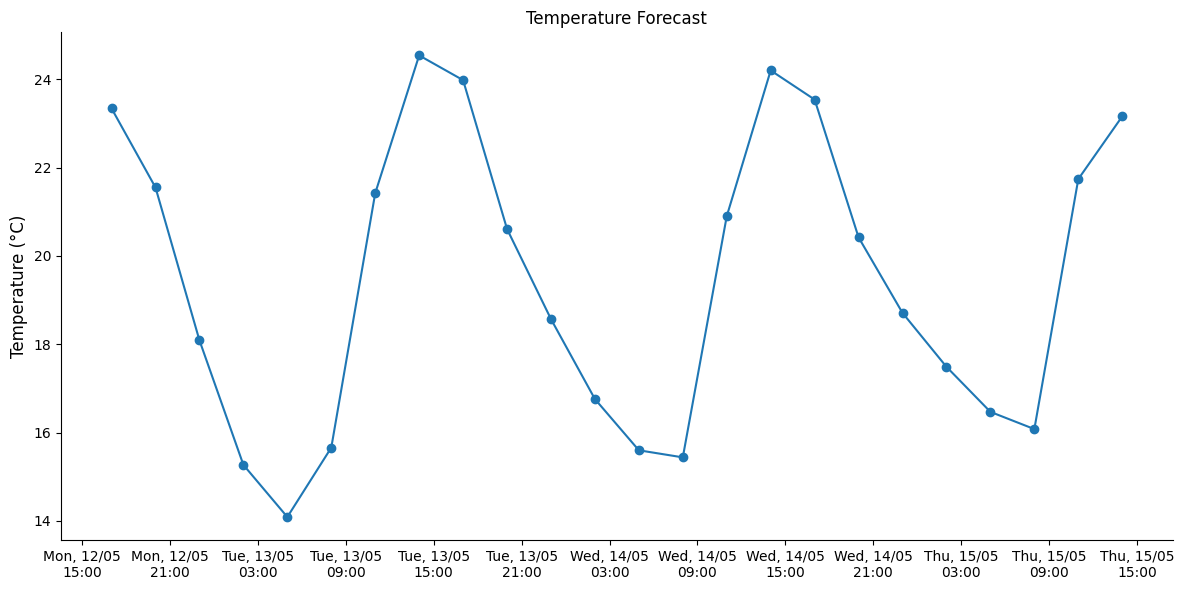

In [42]:
# Include sample input/output for each function

_weather_data = get_weather_data("Perth", forecast_day=3)
if _weather_data:
    create_temperature_visualisation(_weather_data, output_type='display')
else:
    print("Failed to fetch weather data.")



## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.

In [6]:
from datetime import datetime
print (datetime.fromtimestamp(1746165600).strftime('%Y-%m-%d %H:%M:%S'))

2025-05-02 14:00:00


/tmp/ipykernel_29359/2082897893.py:50: UserWarning: Glyph 9925 (\N{SUN BEHIND CLOUD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/35c08f90-43b2-436a-9435-80158dd42ec3/Development/weatherwise-cli/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9925 (\N{SUN BEHIND CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


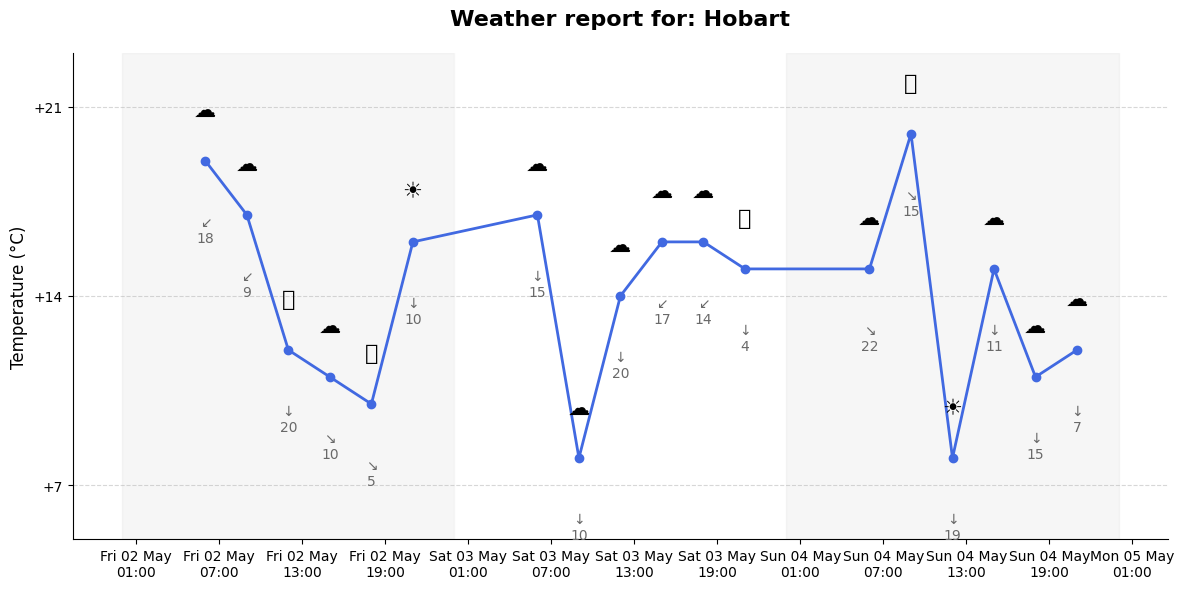

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# Example data
dates = [datetime(2025, 5, 2, h) for h in range(6, 24, 3)] + \
        [datetime(2025, 5, 3, h) for h in range(6, 24, 3)] + \
        [datetime(2025, 5, 4, h) for h in range(6, 24, 3)]
temps = np.random.randint(7, 21, len(dates))
icons = ['☁️', '☁️', '⛅️', '☁️', '⛅️', '☀️', '☁️', '☁️', '☁️'] * 3
wind_dirs = ['↙', '↙', '↓', '↘', '↘', '↓', '↓', '↓', '↓'] * 3
wind_speeds = np.random.randint(4, 24, len(dates))

fig, ax = plt.subplots(figsize=(12, 6))

# Shade background for each day
for i, day in enumerate(sorted(set([d.date() for d in dates]))):
    day_start = datetime.combine(day, datetime.min.time())
    day_end = day_start + timedelta(days=1)
    ax.axvspan(day_start, day_end, color='lightgrey' if i % 2 == 0 else 'white', alpha=0.2, zorder=0)

# Plot temperature
ax.plot(dates, temps, marker='o', color='royalblue', linewidth=2, zorder=2)

# Annotate weather icons and wind
for d, t, icon, wdir, wspd in zip(dates, temps, icons, wind_dirs, wind_speeds):
    ax.text(d, t+1.5, icon, ha='center', va='bottom', fontsize=16)
    ax.text(d, t-2, f"{wdir}\n{wspd}", ha='center', va='top', fontsize=10, color='dimgray')

# Format x-axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b\n%H:%M'))
plt.xticks(rotation=0, ha='center', fontsize=10)

# Y-axis styling
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_ylim(5, 23)
ax.set_yticks([7, 14, 21])
ax.set_yticklabels(['+7', '+14', '+21'])

# Title and grid
ax.set_title('Weather report for: Hobart', fontsize=16, weight='bold', pad=20)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove top/right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
import hands_on_ai.chat
from hands_on_ai.chat import get_response

response = get_response(prompt="hello there", model="llama3")
print(response)


Hello! It's nice to meet you. How can I help you today? Do you have any questions, need assistance with something, or just want to chat? I'm here to listen and assist in any way I can.


In [15]:
from hands_on_ai.config import load_config, get_server_url, get_model, save_config

# Get configuration values
config = load_config()  # Returns dict with all config
model = get_model()     # Get default LLM model
server = get_server_url()  # Get Ollama server URL

# Print configuration values
print(f"Model: {model}")
print(f"Server URL: {server}")

config["model"] = "llama3"
save_config(config)


Model: llama3
Server URL: http://localhost:11434
